In [86]:
%matplotlib inline
import numpy as np
from GBM2 import GBM_KClass,GBM_RandomSearch
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss
import matplotlib.pyplot as plt
import cPickle as pickle
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from copy import copy
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
import pandas as pd

In [2]:
data = np.genfromtxt('/home/will/Desktop/data/Numerai/numerai_training_data.csv', \
                     delimiter=',', skip_header=1)

In [3]:
test = np.genfromtxt('/home/will/Desktop/data/Numerai/numerai_tournament_data.csv', \
                     delimiter=',', skip_header=1)

In [4]:
n_train,_ = data.shape

In [5]:
n_test,_ = test.shape

In [6]:
n = n_test + n_train

1. Build model to predict train vs test

In [183]:
X_ = np.concatenate((data[:,:21],test[:,1:]),0)

In [184]:
y_ = np.zeros(n,dtype='int64')
y_[n_train:] = 1

In [185]:
index=np.random.permutation(n)

In [186]:
X_, y_ = X_[index], y_[index]

In [187]:
X_train, y_train = X_[32389:], y_[32389:]
X_test, y_test = X_[:32389], y_[:32389]

In [188]:
model1=GBM_KClass(ExtraTreeRegressor,50,1e-1,\
{'max_depth':24,'splitter':'random','max_features':0.5},10)

0.53893546409683435

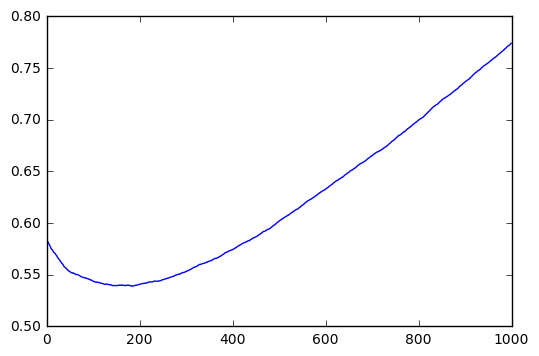

In [13]:
model1.fit(X_train,y_train)

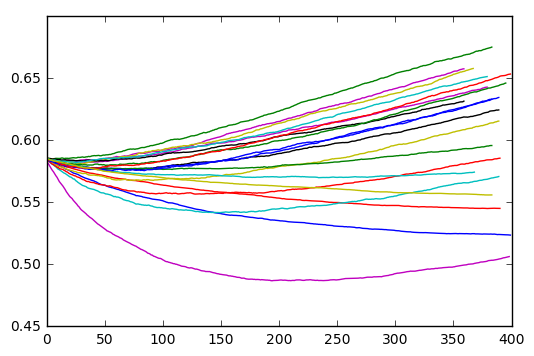

In [11]:
randomSearch = GBM_RandomSearch(X_,y_,20,400,{'BaseEst':ExtraTreeRegressor,'learnRate':1e-1},\
                                [(2,50),(2,48),(0.1,0.9)])

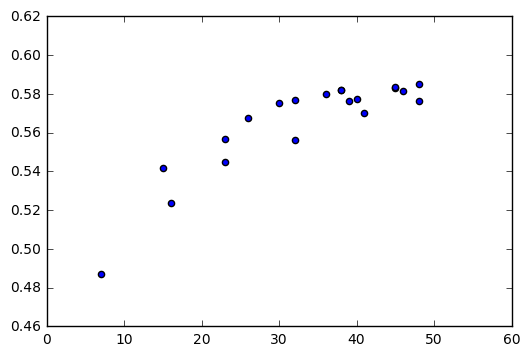

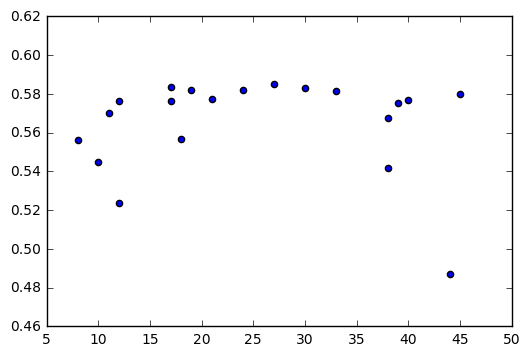

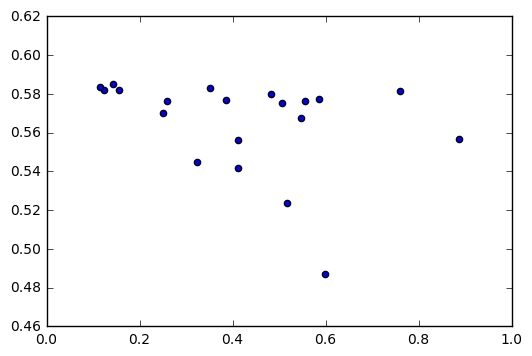

In [19]:
plt.scatter(randomSearch.subFold, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_depth, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_features, randomSearch.acc)

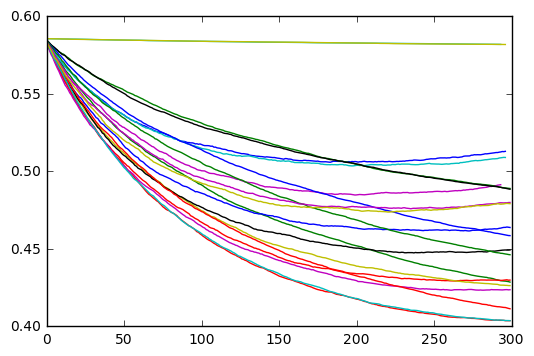

In [20]:
randomSearch = GBM_RandomSearch(X_,y_,20,300,{'BaseEst':ExtraTreeRegressor,'learnRate':1e-1},\
                                [(2,10),(2,48),(0.3,0.9)])

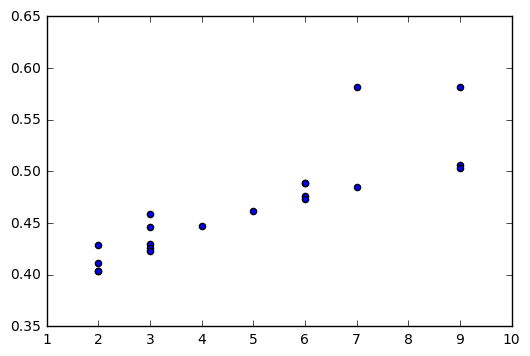

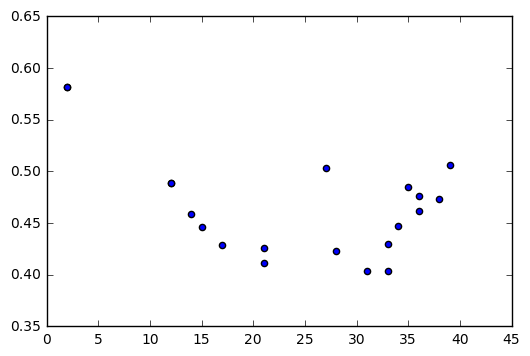

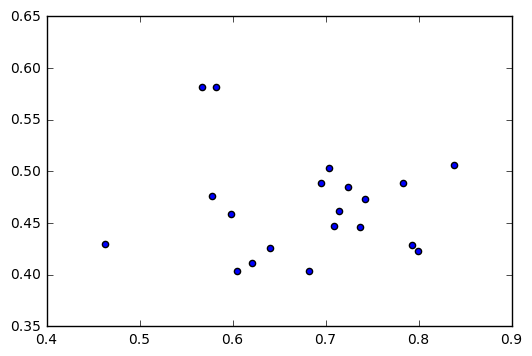

In [21]:
plt.scatter(randomSearch.subFold, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_depth, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_features, randomSearch.acc)

In [22]:
randomSearch

,subFold,max_depth,max_features,acc
0,9.0,39.0,0.838524,0.505914
1,2.0,17.0,0.793329,0.428612
2,3.0,33.0,0.462922,0.429305
3,9.0,27.0,0.703700,0.503568
4,7.0,35.0,0.724524,0.484792
5,3.0,21.0,0.640656,0.426360
6,4.0,34.0,0.709368,0.447452
7,5.0,36.0,0.714902,0.461619
8,6.0,12.0,0.695529,0.489016
9,2.0,31.0,0.682691,0.403697


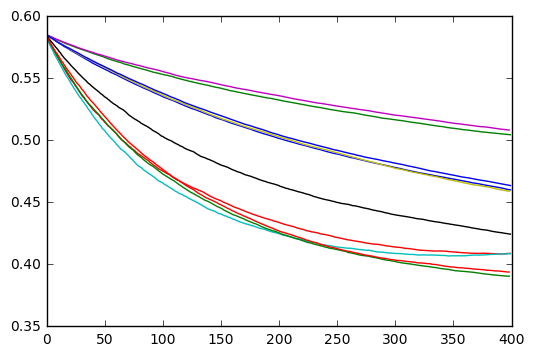

In [12]:
# switch test and train to go to "lower" on subfold
# for test,train in kf:
randomSearch = GBM_RandomSearch(X_,y_,10,400,{'BaseEst':ExtraTreeRegressor,'learnRate':1e-1},\
                                [(2,10),(2,48),(0.3,0.9)])

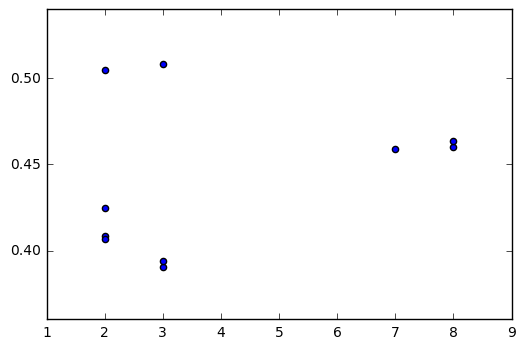

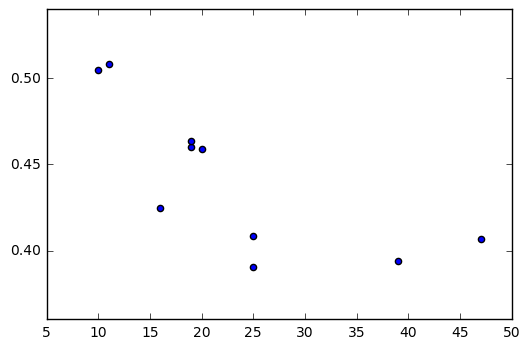

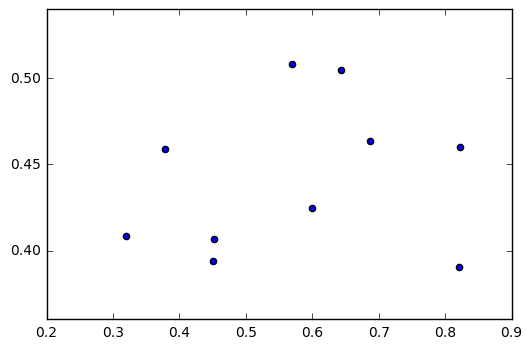

In [13]:
plt.scatter(randomSearch.subFold, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_depth, randomSearch.acc)
plt.show()
plt.scatter(randomSearch.max_features, randomSearch.acc)

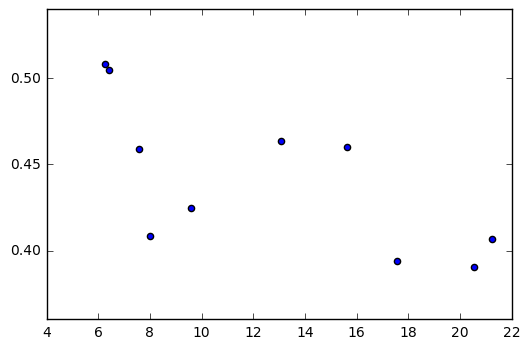

In [15]:
plt.scatter(randomSearch.max_depth * randomSearch.max_features, randomSearch.acc)

In [14]:
randomSearch

,subFold,max_depth,max_features,acc
0,8.0,19.0,0.821791,0.460141
1,2.0,10.0,0.643648,0.504621
2,2.0,25.0,0.320307,0.408493
3,2.0,47.0,0.451761,0.406840
4,3.0,11.0,0.569276,0.508366
5,7.0,20.0,0.378442,0.458979
6,2.0,16.0,0.599047,0.424454
7,8.0,19.0,0.687283,0.463648
8,3.0,25.0,0.821146,0.390509
9,3.0,39.0,0.450331,0.393882


Final model for train vs test

In [189]:
model1=GBM_KClass(ExtraTreeRegressor,1200,1e-2,\
{'max_depth':32,'splitter':'random','max_features':0.6},3)

0.34837837112255177

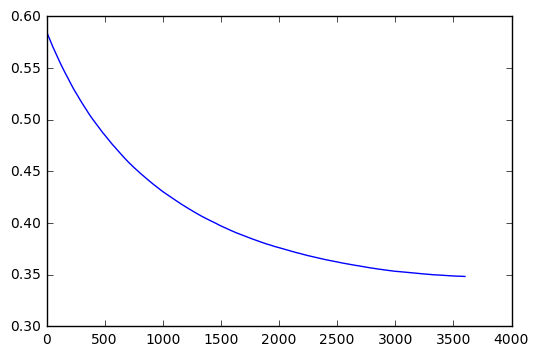

In [190]:
model1.fit(X_,y_)

In [191]:
y_raw=model1.predict_raw(X_)

In [193]:
1.0*np.sum(y_ == np.argmax(y_raw,1)) / y_.shape[0]

1.0

In [21]:
weight_train = model1.predict_raw(data[:,:21])
weight_test = model1.predict_raw(test[:,1:])

In [26]:
with open(r'/home/will/Desktop/data/Numerai/weight_test.pkl', "wb") as output_file:
    pickle.dump(weight_test, output_file)

In [27]:
with open(r'/home/will/Desktop/data/Numerai/weight_train.pkl', "wb") as output_file:
    pickle.dump(weight_train, output_file)

2.Train second stage model 

In [7]:
with open(r'/home/will/Desktop/data/Numerai/weight_test.pkl', "rb") as output_file:
    weight_test=pickle.load(output_file)

In [8]:
with open(r'/home/will/Desktop/data/Numerai/weight_train.pkl', "rb") as output_file:
    weight_train=pickle.load(output_file)

In [25]:
p = 1.0*np.sum(data[:,-1] == 1) / n_train

In [26]:
log_loss(data[:,-1],np.ones_like(data[:,-1])*p)

0.69309371631064298

In [52]:
r = np.linspace(1e-4,2e-3,5) # temperature of log-linear model

In [164]:
P = np.exp(r*np.reshape(weight_train[:,1],(-1,1)))/np.sum(np.exp(r*np.reshape(weight_train,(-1,2,1))),1)

In [152]:
P_ = np.exp(r*np.reshape(weight_test[:,1],(-1,1)))/np.sum(np.exp(r*np.reshape(weight_test,(-1,2,1))),1)

In [55]:
Px = StandardScaler().fit_transform(P)

In [56]:
Px_ = StandardScaler().fit_transform(P_)

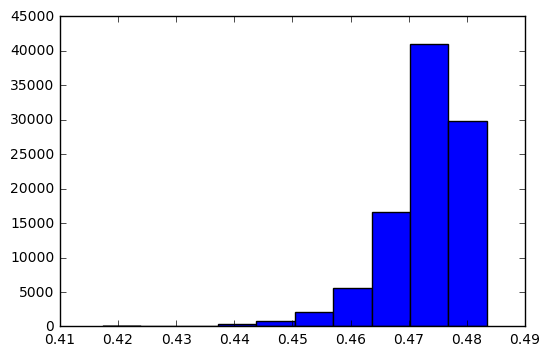

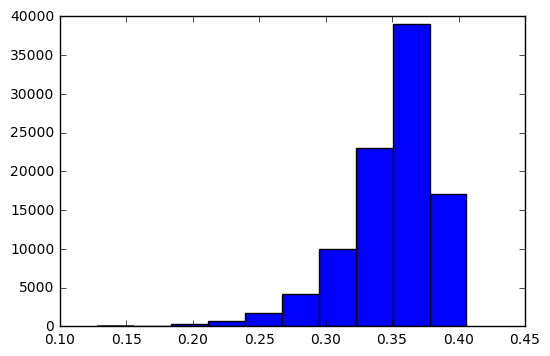

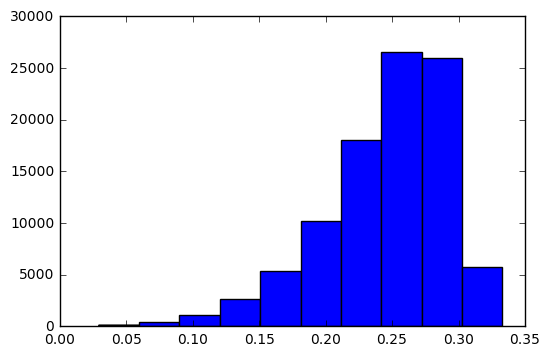

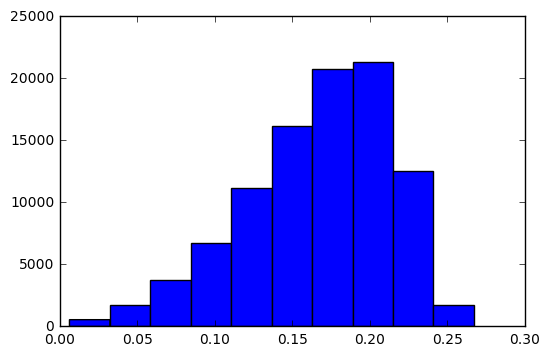

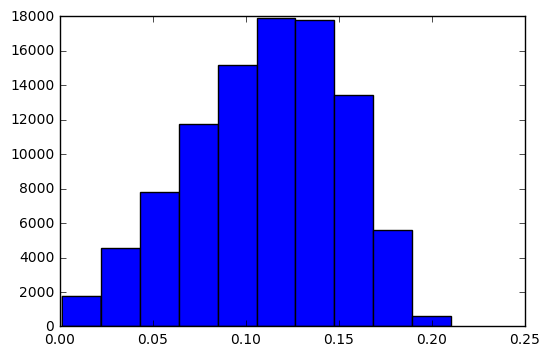

In [21]:
plt.hist(P[:,0])
plt.show()
plt.hist(P[:,1])
plt.show()
plt.hist(P[:,2])
plt.show()
plt.hist(P[:,3])
plt.show()
plt.hist(P[:,4])
plt.show()

Fit a Logistic Regression

In [63]:
y = copy(data[:,-1]).astype('int64')

In [130]:
X0 = copy(data[:,:-1])

In [131]:
X1 = PolynomialFeatures(include_bias=False).fit_transform(X0)

In [132]:
X2 = np.c_[X1,(X1*np.reshape(Px[:,2],(-1,1)))]

In [133]:
scaler1 = StandardScaler().fit(X2)

In [134]:
X3 = scaler1.transform(X2)

In [17]:
model1 = LogisticRegressionCV(Cs=list(np.logspace(-5,0,5)),\
                              cv=4,\
                              scoring='neg_log_loss',\
                              solver='sag',\
                              max_iter=5000)

In [18]:
model1.fit(X3,y) 

LogisticRegressionCV(Cs=[1.0000000000000001e-05, 0.00017782794100389227, 0.0031622776601683794, 0.056234132519034911, 1.0],
           class_weight=None, cv=4, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=5000, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring='neg_log_loss', solver='sag', tol=0.0001, verbose=0)

In [19]:
model1.scores_

{1: array([[-0.69167547, -0.69141254, -0.69182926, -0.69274794, -0.69370934],
        [-0.69115483, -0.69113592, -0.69151643, -0.69212631, -0.69301093],
        [-0.69166727, -0.69147408, -0.69155417, -0.69231151, -0.69289842],
        [-0.69179419, -0.69175927, -0.69225502, -0.69353186, -0.69491252]])}

optimal C around 0.00018

In [69]:
model1 = LogisticRegression(C=0.00018,solver='sag',max_iter=5000)

In [70]:
model1.fit(X3,y, P[:,2]) 

LogisticRegression(C=0.00018, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=5000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [71]:
log_loss(y,model1.predict_proba(X3),sample_weight=P[:,2])

0.69078923055482544

Test set

In [135]:
X0_ = copy(test[:,1:])

In [136]:
X1_ = PolynomialFeatures(include_bias=False).fit_transform(X0_)

In [137]:
X2_ = np.c_[X1_,(X1_*np.reshape(Px_[:,2],(-1,1)))]

In [138]:
X3_ = scaler1.transform(X2_)

In [83]:
yhat1 = model1.predict_proba(X3_)

In [90]:
pd.DataFrame(np.c_[test[:,0].astype('int64'), yhat1[:,1]],columns=['t_id','probability'])\
  .to_csv('/home/will/Desktop/data/Numerai/yhat1.csv', index=False)

** Bagging of LR **

In [94]:
Bagging_X = np.zeros((5,X2.shape[0],X2.shape[1]))
scaler_list = []

In [95]:
for i in range(5):
    temp = np.c_[X1,(X1*np.reshape(Px[:,i],(-1,1)))]
    scaler_list.append(StandardScaler().fit(temp))
    Bagging_X[i] = scaler_list[-1].transform(temp)

In [ ]:
M = 20
estimator_ = []
p_index =[]
feature_index = []
c = 0.001
d = X2.shape[1]
n = X2.shape[0]
feature_p = 0.2
obv_p = 0.2
yhat = np.zeros_like(y)
cum_obv_index = np.zeros_like(y)
for i in range(M):
    p_index.append(np.random.randint(0,5))
    weight_index = np.random.randint(0,5)
    feature_index.append(np.random.rand(d)<feature_p)
    obv_index = np.random.rand(n)<obv_p
    cum_obv_index += obv_index
    estimator_.append(LogisticRegression(C=c,solver='sag',max_iter=5000)\
                      .fit(Bagging_X[p_index[-1]][obv_index][:,feature_index[-1]],y[obv_index],P[:,weight_index]))
    yhat[~obv_index]+=estimator_[-1].predict_proba(Bagging_X[p_index[-1]][~obv_index][:,feature_index[-1]])
    

** GBM **

In [17]:
X_train, y_train, = X3[20000:], y[20000:]
X_test, y_test = X3[:20000], y[:20000]

In [18]:
model1=GBM_KClass(ExtraTreeRegressor,50,5e-2,\
{'max_depth':8,'splitter':'random','max_features':0.2},5)

GBM2.py:140: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weight==None:


0.69197158053228536

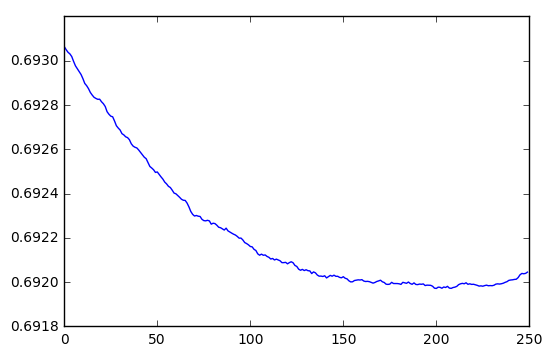

In [19]:
model1.fit(X_train,y_train,P[20000:,2])

GBM2.py:238: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weight!=None:
GBM2.py:244: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weight == None:


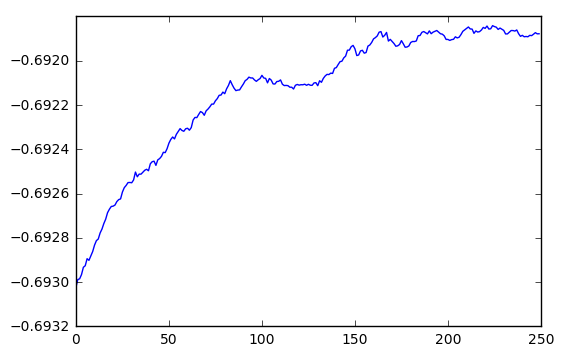

In [20]:
model1.plot_MLE(X_test,y_test,P[:20000,2])

In [ ]:
randomSearch = GBM_RandomSearch(X3,y,20,300,{'BaseEst':ExtraTreeRegressor,'learnRate':5e-2},\
                                [(2,40),(2,24),(0.1,0.5)],P[:,2])

In [169]:
model1=GBM_KClass(ExtraTreeRegressor,400,5e-3,\
{'max_depth':2,'splitter':'random','max_features':0.5},10)

0.69166405768425709

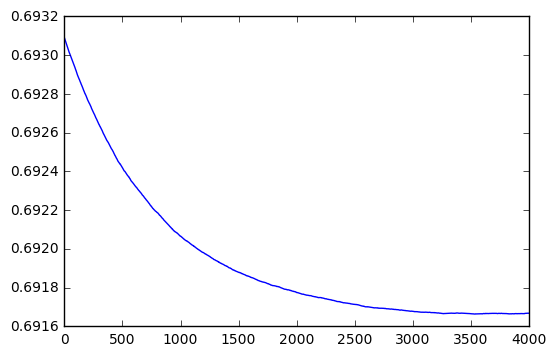

In [166]:
model1.fit(Bagging_X[2],y,P[:,0])

0.69170121426253373

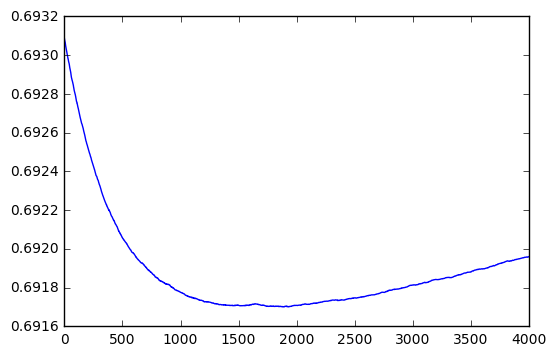

In [170]:
model1.fit(Bagging_X[2],y)

In [177]:
model1.estimator_[1400:] = []

In [179]:
model1.M_est = len(model1.estimator_)

In [146]:
with open(r'/home/will/Desktop/data/Numerai/GBM.pkl', "wb") as output_file:
    pickle.dump(model1, output_file)

In [180]:
P=np.exp(model1.learnRate*model1.predict_raw(X3_))
yhat1=P/np.sum(P,1,keepdims=True)

In [181]:
pd.DataFrame(np.c_[test[:,0].astype('int64'), yhat1[:,1]],columns=['t_id','probability'])\
  .to_csv('/home/will/Desktop/data/Numerai/yhat_GBM.csv', index=False)